# AutoRec模型

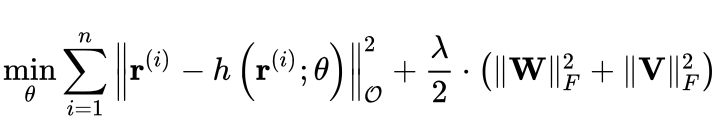

### 简单的三层神经网络，输入物品i的m维向量，经过隐藏层后输出新的m维向量

### 通过训练更新参数矩阵 V 和 W 使得输入输出尽可能的相同

### 损失函数：平方误差加正则
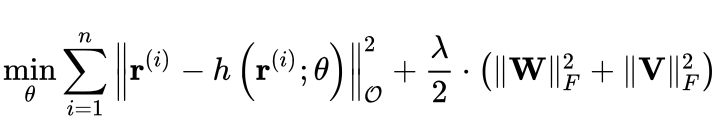

In [28]:
import sys
sys.path.append('/Users/user/miniconda3/lib/python3.8/site-packages')

## 处理数据，生成共现矩阵

In [1]:
import pandas as pd
import numpy as np

In [2]:
rnames = ['user_id', 'movie_id', 'rating','timestamp']
ratings = pd.read_table('ratings.dat',sep= '::', header = None, names = rnames,engine = 'python')
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
print('num of user: ',max(ratings['user_id']))
print('num of movie: ',max(ratings['movie_id']))

num of user:  6040
num of movie:  3952


In [152]:
def getData(ratings,train_ratio):
    split_num=int(max(ratings['movie_id'])*train_ratio)
    # 索引对应id
    data=np.zeros((max(ratings['movie_id'])+1,max(ratings['user_id'])+1))
    for user,mov,rate in zip(ratings['user_id'],ratings['movie_id'],ratings['rating']):
        data[mov][user]=rate
    return data[:split_num,:],data[split_num:,:]

In [164]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import variable
import math
import time
import argparse
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable

In [194]:
train_data,test_data=getData(ratings,0.9)
print(len(train_data))
print(len(train_data[0]))

3556
6041


## 网络模型

In [166]:
class Autorec(nn.Module):
    def __init__(self,n_feature, n_hidden, n_output):
        super(Autorec, self).__init__()
        
        # X=Sigmoid(R*V)
        self.encoder = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.Sigmoid()
        )
        # X*W输出out
        self.decoder = nn.Sequential(
            nn.Linear(n_hidden, n_output),
        )
    
    def forword(self,inp):
        inp=self.encoder(inp)
        out=self.decoder(inp)
        return out
    
class Autorec(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output): 
        super(Autorec, self).__init__()
        # X=Sigmoid(R*V)
        self.encoder = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.Sigmoid()
        )
        # X*W输出out
        self.decoder = nn.Sequential(
            nn.Linear(n_hidden, n_output),
        )
    
    # 将各层的神经元搭建成完整的神经网络的前向通路 
    def forward(self, inp): 
        inp=self.encoder(inp)
        out=self.decoder(inp)
        return out

In [167]:
model=Autorec(6041,500,6041)
cost = nn.MSELoss()
n_epochs = 200
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

Autorec(
  (encoder): Sequential(
    (0): Linear(in_features=6041, out_features=500, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=6041, bias=True)
  )
)

In [195]:
train_data=torch.from_numpy(train_data)
train_data=train_data.float()
train_data=Variable(train_data, requires_grad=True)
train_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 3.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [196]:
test_data=torch.from_numpy(test_data)
test_data=test_data.float()
test_data=Variable(test_data, requires_grad=True)
test_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

## 开始训练

In [172]:
from tqdm import tqdm

In [174]:
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for movie in tqdm(train_data):
        output=model(movie)
        optimizer.zero_grad()
        loss = cost(output, movie)
        loss.backward()
        running_loss+=loss.data
        optimizer.step()

    for movie in tqdm(test_data):
        output=model(movie)
        optimizer.zero_grad()
        loss = cost(output, movie)
    print('loss is ',loss)


  0%|          | 2/3556 [00:00<05:11, 11.40it/s]

Epoch 0/200
----------


  0%|          | 2/3556 [00:00<04:10, 14.17it/s]

loss is  tensor(0.8820, grad_fn=<MseLossBackward>)
Epoch 1/200
----------


  0%|          | 2/3556 [00:00<04:19, 13.70it/s]

loss is  tensor(0.8702, grad_fn=<MseLossBackward>)
Epoch 2/200
----------


  0%|          | 2/3556 [00:00<04:13, 14.04it/s]

loss is  tensor(0.8688, grad_fn=<MseLossBackward>)
Epoch 3/200
----------


  0%|          | 2/3556 [00:00<04:14, 13.94it/s]

loss is  tensor(0.8680, grad_fn=<MseLossBackward>)
Epoch 4/200
----------


  0%|          | 2/3556 [00:00<04:14, 13.98it/s]

loss is  tensor(0.8674, grad_fn=<MseLossBackward>)
Epoch 5/200
----------


  0%|          | 2/3556 [00:00<04:11, 14.13it/s]

loss is  tensor(0.8667, grad_fn=<MseLossBackward>)
Epoch 6/200
----------


  0%|          | 2/3556 [00:00<04:11, 14.16it/s]

loss is  tensor(0.8660, grad_fn=<MseLossBackward>)
Epoch 7/200
----------


  0%|          | 2/3556 [00:00<04:07, 14.35it/s]

loss is  tensor(0.8652, grad_fn=<MseLossBackward>)
Epoch 8/200
----------


  0%|          | 2/3556 [00:00<04:11, 14.13it/s]

loss is  tensor(0.8643, grad_fn=<MseLossBackward>)
Epoch 9/200
----------


  0%|          | 2/3556 [00:00<04:16, 13.87it/s]

loss is  tensor(0.8634, grad_fn=<MseLossBackward>)
Epoch 10/200
----------


  0%|          | 2/3556 [00:00<05:05, 11.65it/s]

loss is  tensor(0.8623, grad_fn=<MseLossBackward>)
Epoch 11/200
----------


  0%|          | 2/3556 [00:00<05:01, 11.80it/s]

loss is  tensor(0.8611, grad_fn=<MseLossBackward>)
Epoch 12/200
----------


  0%|          | 2/3556 [00:00<04:56, 11.99it/s]

loss is  tensor(0.8599, grad_fn=<MseLossBackward>)
Epoch 13/200
----------


  0%|          | 2/3556 [00:00<04:50, 12.22it/s]

loss is  tensor(0.8586, grad_fn=<MseLossBackward>)
Epoch 14/200
----------


  0%|          | 2/3556 [00:00<05:15, 11.25it/s]

loss is  tensor(0.8572, grad_fn=<MseLossBackward>)
Epoch 15/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.54it/s]

loss is  tensor(0.8557, grad_fn=<MseLossBackward>)
Epoch 16/200
----------


  0%|          | 2/3556 [00:00<04:52, 12.13it/s]

loss is  tensor(0.8543, grad_fn=<MseLossBackward>)
Epoch 17/200
----------


  0%|          | 2/3556 [00:00<04:39, 12.73it/s]

loss is  tensor(0.8528, grad_fn=<MseLossBackward>)
Epoch 18/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.08it/s]

loss is  tensor(0.8513, grad_fn=<MseLossBackward>)
Epoch 19/200
----------


  0%|          | 2/3556 [00:00<04:36, 12.83it/s]

loss is  tensor(0.8498, grad_fn=<MseLossBackward>)
Epoch 20/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.52it/s]

loss is  tensor(0.8483, grad_fn=<MseLossBackward>)
Epoch 21/200
----------


  0%|          | 2/3556 [00:00<04:52, 12.13it/s]

loss is  tensor(0.8467, grad_fn=<MseLossBackward>)
Epoch 22/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.60it/s]

loss is  tensor(0.8452, grad_fn=<MseLossBackward>)
Epoch 23/200
----------


  0%|          | 2/3556 [00:00<04:40, 12.67it/s]

loss is  tensor(0.8438, grad_fn=<MseLossBackward>)
Epoch 24/200
----------


  0%|          | 2/3556 [00:00<05:10, 11.45it/s]

loss is  tensor(0.8423, grad_fn=<MseLossBackward>)
Epoch 25/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.56it/s]

loss is  tensor(0.8408, grad_fn=<MseLossBackward>)
Epoch 26/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.34it/s]

loss is  tensor(0.8394, grad_fn=<MseLossBackward>)
Epoch 27/200
----------


  0%|          | 2/3556 [00:00<04:35, 12.89it/s]

loss is  tensor(0.8381, grad_fn=<MseLossBackward>)
Epoch 28/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.55it/s]

loss is  tensor(0.8367, grad_fn=<MseLossBackward>)
Epoch 29/200
----------


  0%|          | 2/3556 [00:00<05:07, 11.55it/s]

loss is  tensor(0.8355, grad_fn=<MseLossBackward>)
Epoch 30/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.52it/s]

loss is  tensor(0.8342, grad_fn=<MseLossBackward>)
Epoch 31/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.59it/s]

loss is  tensor(0.8331, grad_fn=<MseLossBackward>)
Epoch 32/200
----------


  0%|          | 2/3556 [00:00<04:37, 12.82it/s]

loss is  tensor(0.8319, grad_fn=<MseLossBackward>)
Epoch 33/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.38it/s]

loss is  tensor(0.8309, grad_fn=<MseLossBackward>)
Epoch 34/200
----------


  0%|          | 2/3556 [00:00<04:58, 11.92it/s]

loss is  tensor(0.8298, grad_fn=<MseLossBackward>)
Epoch 35/200
----------


  0%|          | 2/3556 [00:00<05:02, 11.75it/s]

loss is  tensor(0.8289, grad_fn=<MseLossBackward>)
Epoch 36/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.38it/s]

loss is  tensor(0.8279, grad_fn=<MseLossBackward>)
Epoch 37/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.41it/s]

loss is  tensor(0.8270, grad_fn=<MseLossBackward>)
Epoch 38/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.43it/s]

loss is  tensor(0.8262, grad_fn=<MseLossBackward>)
Epoch 39/200
----------


  0%|          | 2/3556 [00:00<05:30, 10.75it/s]

loss is  tensor(0.8254, grad_fn=<MseLossBackward>)
Epoch 40/200
----------


  0%|          | 2/3556 [00:00<04:40, 12.66it/s]

loss is  tensor(0.8246, grad_fn=<MseLossBackward>)
Epoch 41/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.60it/s]

loss is  tensor(0.8238, grad_fn=<MseLossBackward>)
Epoch 42/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.46it/s]

loss is  tensor(0.8231, grad_fn=<MseLossBackward>)
Epoch 43/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.35it/s]

loss is  tensor(0.8224, grad_fn=<MseLossBackward>)
Epoch 44/200
----------


  0%|          | 2/3556 [00:00<04:49, 12.28it/s]

loss is  tensor(0.8218, grad_fn=<MseLossBackward>)
Epoch 45/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.07it/s]

loss is  tensor(0.8211, grad_fn=<MseLossBackward>)
Epoch 46/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.47it/s]

loss is  tensor(0.8205, grad_fn=<MseLossBackward>)
Epoch 47/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.40it/s]

loss is  tensor(0.8199, grad_fn=<MseLossBackward>)
Epoch 48/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.47it/s]

loss is  tensor(0.8193, grad_fn=<MseLossBackward>)
Epoch 49/200
----------


  0%|          | 2/3556 [00:00<05:07, 11.54it/s]

loss is  tensor(0.8188, grad_fn=<MseLossBackward>)
Epoch 50/200
----------


  0%|          | 2/3556 [00:00<04:50, 12.24it/s]

loss is  tensor(0.8182, grad_fn=<MseLossBackward>)
Epoch 51/200
----------


  0%|          | 2/3556 [00:00<05:02, 11.76it/s]

loss is  tensor(0.8177, grad_fn=<MseLossBackward>)
Epoch 52/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.09it/s]

loss is  tensor(0.8172, grad_fn=<MseLossBackward>)
Epoch 53/200
----------


  0%|          | 2/3556 [00:00<05:07, 11.54it/s]

loss is  tensor(0.8167, grad_fn=<MseLossBackward>)
Epoch 54/200
----------


  0%|          | 2/3556 [00:00<05:16, 11.23it/s]

loss is  tensor(0.8162, grad_fn=<MseLossBackward>)
Epoch 55/200
----------


  0%|          | 2/3556 [00:00<04:49, 12.26it/s]

loss is  tensor(0.8158, grad_fn=<MseLossBackward>)
Epoch 56/200
----------


  0%|          | 2/3556 [00:00<05:09, 11.49it/s]

loss is  tensor(0.8153, grad_fn=<MseLossBackward>)
Epoch 57/200
----------


  0%|          | 2/3556 [00:00<04:56, 11.98it/s]

loss is  tensor(0.8149, grad_fn=<MseLossBackward>)
Epoch 58/200
----------


  0%|          | 2/3556 [00:00<04:41, 12.62it/s]

loss is  tensor(0.8145, grad_fn=<MseLossBackward>)
Epoch 59/200
----------


  0%|          | 2/3556 [00:00<04:40, 12.66it/s]

loss is  tensor(0.8140, grad_fn=<MseLossBackward>)
Epoch 60/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.55it/s]

loss is  tensor(0.8136, grad_fn=<MseLossBackward>)
Epoch 61/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.57it/s]

loss is  tensor(0.8132, grad_fn=<MseLossBackward>)
Epoch 62/200
----------


  0%|          | 2/3556 [00:00<04:49, 12.29it/s]

loss is  tensor(0.8128, grad_fn=<MseLossBackward>)
Epoch 63/200
----------


  0%|          | 2/3556 [00:00<04:58, 11.90it/s]

loss is  tensor(0.8124, grad_fn=<MseLossBackward>)
Epoch 64/200
----------


  0%|          | 2/3556 [00:00<04:57, 11.94it/s]

loss is  tensor(0.8121, grad_fn=<MseLossBackward>)
Epoch 65/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.12it/s]

loss is  tensor(0.8117, grad_fn=<MseLossBackward>)
Epoch 66/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.60it/s]

loss is  tensor(0.8113, grad_fn=<MseLossBackward>)
Epoch 67/200
----------


  0%|          | 2/3556 [00:00<05:05, 11.63it/s]

loss is  tensor(0.8110, grad_fn=<MseLossBackward>)
Epoch 68/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.45it/s]

loss is  tensor(0.8106, grad_fn=<MseLossBackward>)
Epoch 69/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.48it/s]

loss is  tensor(0.8103, grad_fn=<MseLossBackward>)
Epoch 70/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.40it/s]

loss is  tensor(0.8099, grad_fn=<MseLossBackward>)
Epoch 71/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.52it/s]

loss is  tensor(0.8096, grad_fn=<MseLossBackward>)
Epoch 72/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.13it/s]

loss is  tensor(0.8093, grad_fn=<MseLossBackward>)
Epoch 73/200
----------


  0%|          | 2/3556 [00:00<04:55, 12.03it/s]

loss is  tensor(0.8089, grad_fn=<MseLossBackward>)
Epoch 74/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.37it/s]

loss is  tensor(0.8086, grad_fn=<MseLossBackward>)
Epoch 75/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.11it/s]

loss is  tensor(0.8083, grad_fn=<MseLossBackward>)
Epoch 76/200
----------


  0%|          | 2/3556 [00:00<04:56, 11.99it/s]

loss is  tensor(0.8080, grad_fn=<MseLossBackward>)
Epoch 77/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.12it/s]

loss is  tensor(0.8076, grad_fn=<MseLossBackward>)
Epoch 78/200
----------


  0%|          | 0/3556 [00:00<?, ?it/s]

loss is  tensor(0.8073, grad_fn=<MseLossBackward>)
Epoch 79/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.48it/s]

loss is  tensor(0.8070, grad_fn=<MseLossBackward>)
Epoch 80/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.45it/s]

loss is  tensor(0.8067, grad_fn=<MseLossBackward>)
Epoch 81/200
----------


  0%|          | 2/3556 [00:00<04:35, 12.88it/s]

loss is  tensor(0.8064, grad_fn=<MseLossBackward>)
Epoch 82/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.44it/s]

loss is  tensor(0.8061, grad_fn=<MseLossBackward>)
Epoch 83/200
----------


  0%|          | 2/3556 [00:00<04:52, 12.17it/s]

loss is  tensor(0.8057, grad_fn=<MseLossBackward>)
Epoch 84/200
----------


  0%|          | 2/3556 [00:00<04:36, 12.87it/s]

loss is  tensor(0.8054, grad_fn=<MseLossBackward>)
Epoch 85/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.37it/s]

loss is  tensor(0.8051, grad_fn=<MseLossBackward>)
Epoch 86/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.41it/s]

loss is  tensor(0.8048, grad_fn=<MseLossBackward>)
Epoch 87/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.45it/s]

loss is  tensor(0.8045, grad_fn=<MseLossBackward>)
Epoch 88/200
----------


  0%|          | 2/3556 [00:00<05:02, 11.76it/s]

loss is  tensor(0.8042, grad_fn=<MseLossBackward>)
Epoch 89/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.59it/s]

loss is  tensor(0.8038, grad_fn=<MseLossBackward>)
Epoch 90/200
----------


  0%|          | 2/3556 [00:00<04:36, 12.83it/s]

loss is  tensor(0.8035, grad_fn=<MseLossBackward>)
Epoch 91/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.50it/s]

loss is  tensor(0.8032, grad_fn=<MseLossBackward>)
Epoch 92/200
----------


  0%|          | 2/3556 [00:00<04:50, 12.22it/s]

loss is  tensor(0.8029, grad_fn=<MseLossBackward>)
Epoch 93/200
----------


  0%|          | 2/3556 [00:00<05:08, 11.53it/s]

loss is  tensor(0.8025, grad_fn=<MseLossBackward>)
Epoch 94/200
----------


  0%|          | 2/3556 [00:00<05:07, 11.58it/s]

loss is  tensor(0.8022, grad_fn=<MseLossBackward>)
Epoch 95/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.40it/s]

loss is  tensor(0.8019, grad_fn=<MseLossBackward>)
Epoch 96/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.46it/s]

loss is  tensor(0.8015, grad_fn=<MseLossBackward>)
Epoch 97/200
----------


  0%|          | 2/3556 [00:00<04:40, 12.68it/s]

loss is  tensor(0.8012, grad_fn=<MseLossBackward>)
Epoch 98/200
----------


  0%|          | 2/3556 [00:00<04:36, 12.87it/s]

loss is  tensor(0.8009, grad_fn=<MseLossBackward>)
Epoch 99/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.08it/s]

loss is  tensor(0.8005, grad_fn=<MseLossBackward>)
Epoch 100/200
----------


  0%|          | 2/3556 [00:00<05:04, 11.67it/s]

loss is  tensor(0.8002, grad_fn=<MseLossBackward>)
Epoch 101/200
----------


  0%|          | 2/3556 [00:00<04:51, 12.20it/s]

loss is  tensor(0.7998, grad_fn=<MseLossBackward>)
Epoch 102/200
----------


  0%|          | 2/3556 [00:00<05:11, 11.42it/s]

loss is  tensor(0.7995, grad_fn=<MseLossBackward>)
Epoch 103/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.33it/s]

loss is  tensor(0.7991, grad_fn=<MseLossBackward>)
Epoch 104/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.30it/s]

loss is  tensor(0.7988, grad_fn=<MseLossBackward>)
Epoch 105/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.57it/s]

loss is  tensor(0.7984, grad_fn=<MseLossBackward>)
Epoch 106/200
----------


  0%|          | 2/3556 [00:00<04:41, 12.61it/s]

loss is  tensor(0.7981, grad_fn=<MseLossBackward>)
Epoch 107/200
----------


  0%|          | 2/3556 [00:00<04:41, 12.61it/s]

loss is  tensor(0.7977, grad_fn=<MseLossBackward>)
Epoch 108/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.34it/s]

loss is  tensor(0.7974, grad_fn=<MseLossBackward>)
Epoch 109/200
----------


  0%|          | 0/3556 [00:00<?, ?it/s]

loss is  tensor(0.7970, grad_fn=<MseLossBackward>)
Epoch 110/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.30it/s]

loss is  tensor(0.7966, grad_fn=<MseLossBackward>)
Epoch 111/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.57it/s]

loss is  tensor(0.7963, grad_fn=<MseLossBackward>)
Epoch 112/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.33it/s]

loss is  tensor(0.7959, grad_fn=<MseLossBackward>)
Epoch 113/200
----------


  0%|          | 2/3556 [00:00<05:02, 11.76it/s]

loss is  tensor(0.7955, grad_fn=<MseLossBackward>)
Epoch 114/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.11it/s]

loss is  tensor(0.7952, grad_fn=<MseLossBackward>)
Epoch 115/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.33it/s]

loss is  tensor(0.7948, grad_fn=<MseLossBackward>)
Epoch 116/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.31it/s]

loss is  tensor(0.7944, grad_fn=<MseLossBackward>)
Epoch 117/200
----------


  0%|          | 2/3556 [00:00<05:16, 11.24it/s]

loss is  tensor(0.7941, grad_fn=<MseLossBackward>)
Epoch 118/200
----------


  0%|          | 2/3556 [00:00<04:59, 11.87it/s]

loss is  tensor(0.7937, grad_fn=<MseLossBackward>)
Epoch 119/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.07it/s]

loss is  tensor(0.7933, grad_fn=<MseLossBackward>)
Epoch 120/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.34it/s]

loss is  tensor(0.7929, grad_fn=<MseLossBackward>)
Epoch 121/200
----------


  0%|          | 2/3556 [00:00<04:35, 12.89it/s]

loss is  tensor(0.7926, grad_fn=<MseLossBackward>)
Epoch 122/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.13it/s]

loss is  tensor(0.7922, grad_fn=<MseLossBackward>)
Epoch 123/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.53it/s]

loss is  tensor(0.7918, grad_fn=<MseLossBackward>)
Epoch 124/200
----------


  0%|          | 2/3556 [00:00<04:55, 12.02it/s]

loss is  tensor(0.7914, grad_fn=<MseLossBackward>)
Epoch 125/200
----------


  0%|          | 2/3556 [00:00<04:56, 11.98it/s]

loss is  tensor(0.7911, grad_fn=<MseLossBackward>)
Epoch 126/200
----------


  0%|          | 2/3556 [00:00<04:48, 12.31it/s]

loss is  tensor(0.7907, grad_fn=<MseLossBackward>)
Epoch 127/200
----------


  0%|          | 2/3556 [00:00<04:53, 12.11it/s]

loss is  tensor(0.7903, grad_fn=<MseLossBackward>)
Epoch 128/200
----------


  0%|          | 2/3556 [00:00<04:37, 12.82it/s]

loss is  tensor(0.7899, grad_fn=<MseLossBackward>)
Epoch 129/200
----------


  0%|          | 2/3556 [00:00<05:09, 11.48it/s]

loss is  tensor(0.7895, grad_fn=<MseLossBackward>)
Epoch 130/200
----------


  0%|          | 2/3556 [00:00<05:00, 11.81it/s]

loss is  tensor(0.7892, grad_fn=<MseLossBackward>)
Epoch 131/200
----------


  0%|          | 2/3556 [00:00<04:42, 12.56it/s]

loss is  tensor(0.7888, grad_fn=<MseLossBackward>)
Epoch 132/200
----------


  0%|          | 2/3556 [00:00<04:39, 12.72it/s]

loss is  tensor(0.7884, grad_fn=<MseLossBackward>)
Epoch 133/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.49it/s]

loss is  tensor(0.7880, grad_fn=<MseLossBackward>)
Epoch 134/200
----------


  0%|          | 2/3556 [00:00<04:51, 12.21it/s]

loss is  tensor(0.7876, grad_fn=<MseLossBackward>)
Epoch 135/200
----------


  0%|          | 2/3556 [00:00<04:52, 12.14it/s]

loss is  tensor(0.7872, grad_fn=<MseLossBackward>)
Epoch 136/200
----------


  0%|          | 2/3556 [00:00<04:47, 12.38it/s]

loss is  tensor(0.7869, grad_fn=<MseLossBackward>)
Epoch 137/200
----------


  0%|          | 2/3556 [00:00<04:46, 12.39it/s]

loss is  tensor(0.7865, grad_fn=<MseLossBackward>)
Epoch 138/200
----------


  0%|          | 2/3556 [00:00<04:43, 12.54it/s]

loss is  tensor(0.7861, grad_fn=<MseLossBackward>)
Epoch 139/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.49it/s]

loss is  tensor(0.7857, grad_fn=<MseLossBackward>)
Epoch 140/200
----------


  0%|          | 2/3556 [00:00<04:59, 11.85it/s]

loss is  tensor(0.7853, grad_fn=<MseLossBackward>)
Epoch 141/200
----------


  0%|          | 2/3556 [00:00<04:44, 12.48it/s]

loss is  tensor(0.7850, grad_fn=<MseLossBackward>)
Epoch 142/200
----------


  0%|          | 2/3556 [00:00<05:10, 11.43it/s]

loss is  tensor(0.7846, grad_fn=<MseLossBackward>)
Epoch 143/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.06it/s]

loss is  tensor(0.7842, grad_fn=<MseLossBackward>)
Epoch 144/200
----------


  0%|          | 2/3556 [00:00<05:23, 10.97it/s]

loss is  tensor(0.7838, grad_fn=<MseLossBackward>)
Epoch 145/200
----------


  0%|          | 2/3556 [00:00<04:51, 12.19it/s]

loss is  tensor(0.7834, grad_fn=<MseLossBackward>)
Epoch 146/200
----------


  0%|          | 0/3556 [00:00<?, ?it/s]

loss is  tensor(0.7831, grad_fn=<MseLossBackward>)
Epoch 147/200
----------


  0%|          | 2/3556 [00:00<05:06, 11.61it/s]

loss is  tensor(0.7827, grad_fn=<MseLossBackward>)
Epoch 148/200
----------


  0%|          | 2/3556 [00:00<05:07, 11.56it/s]

loss is  tensor(0.7823, grad_fn=<MseLossBackward>)
Epoch 149/200
----------


  0%|          | 2/3556 [00:00<05:18, 11.15it/s]

loss is  tensor(0.7819, grad_fn=<MseLossBackward>)
Epoch 150/200
----------


  0%|          | 2/3556 [00:00<05:00, 11.82it/s]

loss is  tensor(0.7816, grad_fn=<MseLossBackward>)
Epoch 151/200
----------


  0%|          | 2/3556 [00:00<05:03, 11.71it/s]

loss is  tensor(0.7812, grad_fn=<MseLossBackward>)
Epoch 152/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.45it/s]

loss is  tensor(0.7808, grad_fn=<MseLossBackward>)
Epoch 153/200
----------


  0%|          | 2/3556 [00:00<05:08, 11.51it/s]

loss is  tensor(0.7804, grad_fn=<MseLossBackward>)
Epoch 154/200
----------


  0%|          | 2/3556 [00:00<04:45, 12.43it/s]

loss is  tensor(0.7800, grad_fn=<MseLossBackward>)
Epoch 155/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.05it/s]

loss is  tensor(0.7797, grad_fn=<MseLossBackward>)
Epoch 156/200
----------


  0%|          | 2/3556 [00:00<04:54, 12.06it/s]

loss is  tensor(0.7793, grad_fn=<MseLossBackward>)
Epoch 157/200
----------


  0%|          | 2/3556 [00:00<05:06, 11.61it/s]

loss is  tensor(0.7789, grad_fn=<MseLossBackward>)
Epoch 158/200
----------


 50%|████▉     | 1774/3556 [02:16<02:16, 13.01it/s]


KeyboardInterrupt: 

## 训练完成，topN排序

In [222]:
prediction=model(test_data)
prediction=prediction.detach().numpy()
prediction

array([[-0.10920732,  0.16217954, -0.13245669, ..., -0.03711066,
         0.17799789,  0.62468886],
       [-0.0279699 , -0.10099082, -0.05305667, ...,  0.01707601,
         0.05812037, -0.10651678],
       [ 0.00634375,  0.00187417,  0.01216695, ...,  0.00982976,
         0.02290542,  0.05429372],
       ...,
       [-0.10183141,  0.01941234,  0.00999586, ..., -0.06937908,
        -0.03200007,  0.13236664],
       [ 0.00910299,  0.02591625, -0.08693105, ..., -0.00739625,
        -0.06808564,  0.08092597],
       [ 0.06387672,  0.43498132,  0.38133895, ..., -0.09504116,
         0.09913957,  0.7396383 ]], dtype=float32)

In [225]:
test=test_data.detach().numpy()
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 将测试集中的电影推荐给20位用户，计算点击率

In [231]:
predNum=200
from random import randint
ctr=0
for i in range(predNum):
    right=0
    idx=randint(1,len(test)-1)
    pred=np.argsort(prediction[idx])[-20:]
    for j in pred:
        if test[idx][j]!=0:
            right+=1
    ctr+=right/20
ctr=100*ctr/predNum
print('top20 CTR = ',ctr,'%')

top20 CTR =  52.34999999999998 %


## 总结

### 网络结构太简单，只有一层隐藏层，比传统推荐算法有更好的表达能力，但对复杂情况拟合能力不足，和Word2Vec模型几乎一样